**Importing libraries**

In [1]:
# Keras e TF

#import tensorflow
import tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint

# Sk-Learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, accuracy_score, classification_report, confusion_matrix

# Base
import os 
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns # 
import numpy as np #
import pandas as pd # 

from keras.utils import load_img

import pydot
import pydotplus
from pydotplus import graphviz

from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from custom_resnet import ResNet18


from keras.models import Model
from keras.optimizers import Adam

In [2]:
keras.__version__

'2.10.0'

**Setting path to the dataset**

In [2]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute().parent.absolute()) +
              '\\adni-images-Full-resized160x192'))

In [3]:
print(os.getcwd())

d:\Projects\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\adni-images-Full-resized160x192


# Loading Dataset

In [4]:
data_dir = Path(os.getcwd())

def data_mean_std():
    names = []
    for root, dirs, files in os.walk(data_dir):
        if "train" in root:
            for file in files:
                names.append(root + '/' + file)
    
    print(len(names))
                
    array = []
    for name in names:
        try:
            img = load_img(name, color_mode = 'grayscale', target_size = (160, 192))
            img_array = np.asarray(img)
            array.append(img_array)
        except:
            print("Name: ", name)
            continue
    
    print(img_array.shape) # Correct amount of images

    array = np.asarray(array)
    print(array.shape)
    print(array.mean().shape, array.std().shape)
    return array.mean(), array.std()
""" 
stats_file = open(stats_path, 'r')
stats_lst = stats_file.read().split('\n')
mean = float(stats_lst[0])
std = float(stats_lst[1])"""
mean, std = data_mean_std()

print(mean, std)


218576
Name:  d:\Projects\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\adni-images-Full-resized160x192\train_gan_over\ad/fake_ad_19058.png
(160, 192)
(218575, 160, 192)
() ()
35.80925715423529 45.16736479384096


Use the pre-computed values (no balance):

In [4]:
mean = 35.80925715423529
std = 45.16736479384096

In [5]:
# STANDARDIZZAZIONE
def normalize(x):
    return (x - mean) / std

In [ ]:
def prep_fn(img):
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) * 2
    return img

In [4]:
batch_size = 32 # Batch size

train_path = './train'
test_path = './test'
valid_path = './valid'
#rescale = 1./255.
# train_datagen = ImageDataGenerator(preprocessing_function = normalize)
# test_datagen = ImageDataGenerator(preprocessing_function = normalize)
# valid_datagen = ImageDataGenerator(preprocessing_function = normalize)

train_datagen = ImageDataGenerator(rescale= 1./255.)
test_datagen = ImageDataGenerator(rescale= 1./255.)
valid_datagen = ImageDataGenerator(rescale= 1./255.)

In [5]:
train_data = train_datagen.flow_from_directory(
        train_path,
        color_mode = 'grayscale',
        target_size=(192, 160),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        class_mode='categorical')

Found 134608 images belonging to 3 classes.


In [6]:
validation_data = valid_datagen.flow_from_directory(
        valid_path,
        color_mode='grayscale',
        target_size=(192, 160),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        class_mode='categorical')

Found 18024 images belonging to 3 classes.


In [7]:
# Test set
test_data = test_datagen.flow_from_directory(
        test_path,
        color_mode='grayscale',
        target_size=(192, 160),  # Lo inserisco per precauzione
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 10567 images belonging to 3 classes.


In [11]:
train_data.class_indices

{'ad': 0, 'mci': 1, 'nor': 2}

In [12]:
validation_data.class_indices

{'ad': 0, 'mci': 1, 'nor': 2}

In [13]:
test_data.class_indices

{'ad': 0, 'mci': 1, 'nor': 2}

In [8]:
train_ad = len(os.listdir(os.getcwd() + '\\train\\ad'))
train_nor = len(os.listdir(os.getcwd() + '\\train\\nor'))
train_mci = len(os.listdir(os.getcwd() + '\\train\\mci'))
train_tot = train_ad + train_nor + train_mci
print(train_ad/train_tot, train_nor/train_tot, train_mci/train_tot)

0.1644701652204921 0.29484874598835137 0.5406810887911565


In [9]:
test_ad = len(os.listdir(os.getcwd() + '\\test\\ad'))
test_nor = len(os.listdir(os.getcwd() + '\\test\\nor'))
test_mci = len(os.listdir(os.getcwd() + '\\test\\mci'))
test_tot = test_ad + test_nor + test_mci
print(test_ad/test_tot, test_nor/test_tot, test_mci/test_tot)

0.22504021955143372 0.20762751963660453 0.5673322608119618


In [10]:
valid_ad = len(os.listdir(os.getcwd() + '\\valid\\ad'))
valid_nor = len(os.listdir(os.getcwd() + '\\valid\\nor'))
valid_mci = len(os.listdir(os.getcwd() + '\\valid\\mci'))
valid_tot = valid_ad + valid_nor + valid_mci
print(valid_ad/valid_tot, valid_nor/valid_tot, valid_mci/valid_tot)

0.22253661784287618 0.37377940523746117 0.4036839769196627


## Check scaling

In [11]:
batch = train_data.next() 
num_images = batch[0].shape[0]
image_height = batch[0].shape[1]
image_width = batch[0].shape[2]
min_value = batch[0].min()
max_value = batch[0].max()
print("Numero di immagini nel batch:", num_images)
print("Dimensioni delle immagini (altezza x larghezza):", image_height, "x", image_width)
print("Valore minimo dei pixel:", min_value)
print("Valore massimo dei pixel:", max_value)

Numero di immagini nel batch: 32
Dimensioni delle immagini (altezza x larghezza): 192 x 160
Valore minimo dei pixel: 0.0
Valore massimo dei pixel: 1.0


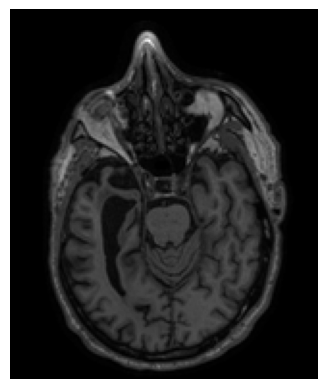

In [12]:
image = batch[0][0]
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
ax.axis('off')  # Rimuovi gli assi
plt.show()

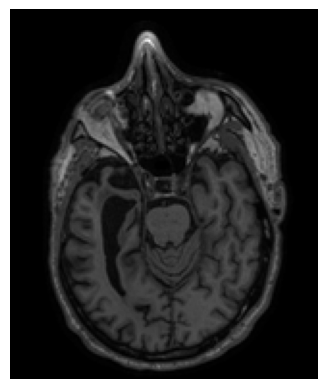

In [14]:
# Scalare i pixel tra 0 e 1
scaled_image = image / max_value

# Visualizzare l'immagine scalata
fig, ax = plt.subplots()
ax.imshow(scaled_image, cmap='gray')
ax.axis('off')
plt.show()

In [15]:
# Calcola la media del batch
mean_value = np.mean(batch[0])

# Calcola la deviazione standard del batch
std_value = np.std(batch[0])

# Stampa i risultati
print("Media del batch:", mean_value)
print("Deviazione standard del batch:", std_value)

Media del batch: 0.14325565
Deviazione standard del batch: 0.17840801


# Model Definition

Changing the folder to data path to save weights into

In [16]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute()) + '\\scripts\\3_Resnet18_first'))

In [17]:
os.getcwd()

'd:\\Projects\\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\\scripts\\3_Resnet18_first'

In [18]:
METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.TopKCategoricalAccuracy(name='top 2 accuracy', k=2),
      keras.metrics.TopKCategoricalAccuracy(name='top 3 accuracy', k=3),
      keras.metrics.TopKCategoricalAccuracy(name='top 5 accuracy', k=5)
]

In [19]:
early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [20]:
from tensorflow.keras import initializers

tb = TensorBoard(log_dir =os.getcwd() + '\\no_balance\\logs_no_balance', write_graph = True)

lr_reducer = ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.1), patience=10, cooldown=0, min_lr=1e-5)

model_chkp = ModelCheckpoint(filepath=os.getcwd() + '\\no_balance\\best_model_no_balance',
                            # monitor='val_quadratic_kappa_score',
                            monitor='val_accuracy',
                            save_best_only=True, save_weights_only=True, mode='max')

#resnet = ResNet18()
#resnet = ResNet18(classes=3, input_shape=(160, 192))
resnet = ResNet18(classes=3)


#model = keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#model.summary()

#resnet.layers.pop()
#for layer in resnet.layers:
#    layer.trainable = False

x = resnet.layers[-1].output

#x = Dropout(0.25)(x)

x = Dense(3, activation = 'softmax')(x)

#x = Dropout(0.25)(x)

ft_resnet = Model(resnet.input, x)
optimizer = Adam(learning_rate = 0.001)
ft_resnet.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = METRICS)

print("model loaded")

ft_resnet.summary()

<class 'keras.engine.keras_tensor.KerasTensor'>
model loaded
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 166, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 96, 80, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization)  (

Changing back the folder to data path

In [21]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute().parent.absolute()) + '\\adni-images-Full-resized160x192'))
os.getcwd()

'd:\\Projects\\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\\adni-images-Full-resized160x192'

In [22]:
version = "v2"
epochs = 10

print(train_tot, valid_tot)

train_steps = np.ceil(train_tot/batch_size)
valid_steps = np.ceil(valid_tot/batch_size)

print (train_steps, valid_steps)

#fit_generator

history_dcnn = ft_resnet.fit(train_data, 
                             steps_per_epoch=train_steps,
                             epochs=epochs,
                             workers = 4,
                             callbacks = [tb, model_chkp, early_stopper, lr_reducer],
                             validation_data = validation_data, 
                             validation_steps = valid_steps)


134608 18024
4207.0 564.0
Epoch 1/10
4207/4207 [==============================] - 244s 57ms/step - loss: 0.8742 - accuracy: 0.6005 - precision: 0.6374 - recall: 0.5066 - auc: 0.7831 - top 2 accuracy: 0.8836 - top 3 accuracy: 1.0000 - top 5 accuracy: 1.0000 - val_loss: 1.3477 - val_accuracy: 0.4161 - val_precision: 0.4214 - val_recall: 0.3450 - val_auc: 0.6058 - val_top 2 accuracy: 0.7875 - val_top 3 accuracy: 1.0000 - val_top 5 accuracy: 1.0000 - lr: 0.0010
Epoch 2/10
4207/4207 [==============================] - 236s 56ms/step - loss: 0.5332 - accuracy: 0.7777 - precision: 0.8019 - recall: 0.7466 - auc: 0.9227 - top 2 accuracy: 0.9534 - top 3 accuracy: 1.0000 - top 5 accuracy: 1.0000 - val_loss: 3.2621 - val_accuracy: 0.4108 - val_precision: 0.4120 - val_recall: 0.4084 - val_auc: 0.5746 - val_top 2 accuracy: 0.6992 - val_top 3 accuracy: 1.0000 - val_top 5 accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
4207/4207 [==============================] - 236s 56ms/step - loss: 0.2651 - accuracy: 0.89

In [23]:
arch_name = 'bs_{}'.format(batch_size)

continue_model_path = '..\\models\\best_model_no_balance\\' + '{}_{}_{}_eps.h5'.format(version, arch_name, epochs)
ft_resnet.save(continue_model_path)
np.save(f'..\\models\\best_model_no_balance\\{version}_{arch_name}_{epochs}_eps.npy',
        history_dcnn.history)

In [24]:
import pickle 
ft_resnet.save_weights('..\\models\\best_model_no_balance\\' + '{}_{}_{}_eps_wheights_only.h5'.format(version, arch_name, epochs))
symbolic_weights = getattr(ft_resnet.optimizer, 'weights')
weight_values = K.batch_get_value(symbolic_weights)
with open('..\\models\\best_model_no_balance\\' + '{}_{}_{}_eps_optimizer.pkl'.format(version, arch_name, epochs), 'wb') as f:
    pickle.dump(weight_values, f)

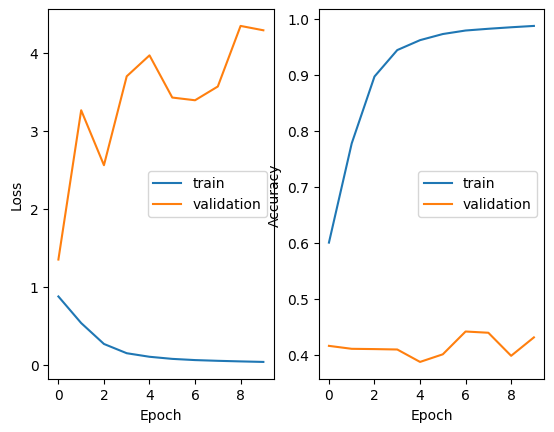

In [25]:
# Visualization of the learning curves

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_dcnn.history['loss'])
plt.plot(history_dcnn.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dcnn.history['accuracy'])
plt.plot(history_dcnn.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

# Continue training

In [27]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute()) + '\\scripts\\3_Resnet18_first'))

In [28]:
os.getcwd()

'd:\\Projects\\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\\scripts\\3_Resnet18_first'

In [29]:
METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.TopKCategoricalAccuracy(name='top 2 accuracy', k=2),
      keras.metrics.TopKCategoricalAccuracy(name='top 3 accuracy', k=3),
      keras.metrics.TopKCategoricalAccuracy(name='top 5 accuracy', k=5)
]

In [30]:
early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [31]:
tb = TensorBoard(log_dir =os.getcwd() + '\\gan_over\\logs_gan_over', write_graph = True)

lr_reducer = ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.1), patience=10, cooldown=0, min_lr=1e-5)

model_chkp = ModelCheckpoint(filepath=os.getcwd() + '\\gan_over\\best_model_gan_over',
                            # monitor='val_quadratic_kappa_score',
                            monitor='val_accuracy',
                            save_best_only=True, save_weights_only=True, mode='max')

#resnet = ResNet18()
#resnet = ResNet18(classes=3, input_shape=(160, 192))
resnet = ResNet18(classes=3)


#model = keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#model.summary()

#resnet.layers.pop()
#for layer in resnet.layers:
#    layer.trainable = False

x = resnet.layers[-1].output

x = Dropout(0.25)(x)

x = Dense(3, activation = 'softmax')(x)


ft_resnet = Model(resnet.input, x)
ft_resnet.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = METRICS)

print("model loaded")

ft_resnet.summary()

<class 'keras.engine.keras_tensor.KerasTensor'>
model loaded
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 192, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 166, 1)  0           ['input_3[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 96, 80, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization) 

Changing back the folder to data path

In [32]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute().parent.absolute()) + '\\adni-images-Full-resized160x192'))
os.getcwd()

'd:\\Projects\\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\\adni-images-Full-resized160x192'

In [33]:
print(train_tot, valid_tot)

train_steps = np.ceil(train_tot/batch_size)
valid_steps = np.ceil(valid_tot/batch_size)

print (train_steps, valid_steps)

218575 18024
6831.0 564.0


In [39]:
import pickle 
import tensorflow

ft_resnet = tensorflow.keras.models.load_model('..\\models\\best_model_gan_over\\' + '{}_{}_{}_eps.h5'.format(version, arch_name, epochs))
old_weights = ft_resnet.optimizier.get_weights()

ft_resnet._make_train_function()
with open('..\\models\\best_model_gan_over\\' + '{}_{}_{}_eps_optimizer.pkl'.format(version, arch_name, epochs), 'rb') as f:
    weight_values = pickle.load(f)
ft_resnet.optimizer.set_weights(weight_values)

AttributeError: 'Functional' object has no attribute 'optimizier'

In [38]:
import pickle 

ft_resnet.load_weights('..\\models\\best_model_gan_over\\' + '{}_{}_{}_eps.h5'.format(version, arch_name, epochs))
ft_resnet.make_train_function()
with open('..\\models\\best_model_gan_over\\' + '{}_{}_{}_eps_optimizer.pkl'.format(version, arch_name, epochs), 'rb') as f:
    weight_values = pickle.load(f)
ft_resnet.optimizer.set_weights(weight_values)

#fit_generator


AttributeError: 'Functional' object has no attribute 'load_model'

In [ ]:
version = "v2"
epochs = 30

In [ ]:
history_dcnn = ft_resnet.fit(train_data, 
                             steps_per_epoch=train_steps,
                             epochs=epochs,
                             workers = 4,
                             callbacks = [tb, model_chkp, lr_reducer, early_stopper],
                             validation_data = validation_data, 
                             validation_steps = valid_steps)


In [ ]:
arch_name = 'bs_{}'.format(batch_size)

continue_model_path = '..\\models\\best_model_gan_over\\' + '{}_{}_{}_eps.h5'.format(version, arch_name, epochs)
ft_resnet.save(continue_model_path)
np.save(f'..\\models\\best_model_gan_over\\{version}_{arch_name}_{epochs}_eps.npy',
        history_dcnn.history)

In [ ]:
import pickle 
ft_resnet.save_weights('..\\models\\best_model_gan_over\\' + '{}_{}_{}_eps_wheights_only.h5'.format(version, arch_name, epochs))
symbolic_weights = getattr(ft_resnet.optimizer, 'weights')
weight_values = K.batch_get_value(symbolic_weights)
with open('..\\models\\best_model_gan_over\\' + '{}_{}_{}_eps_optimizer.pkl'.format(version, arch_name, epochs), 'wb') as f:
    pickle.dump(weight_values, f)

# Load Model

In [8]:
#os.chdir('C:/Users/marco/Desktop/Local_Documents/models/NoBalance')

In [33]:
# Load model
net_dcnn = keras.models.load_model("..\\models\\best_model_no_balance\\v1_bs_32_100_eps.h5")

In [34]:
# Load hystory and convert to dict
history = np.load('..\\models\\best_model_no_balance\\v1_bs_32_100_eps.npy', allow_pickle=True).item()

# Model Evaluation

In [35]:
# Set visualization size for figures 
plt.rcParams['figure.figsize'] = [5,5] # width, height

In [36]:
CATEGORIES = "ad", "mci","nor"

In [37]:
history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'top 2 accuracy', 'top 3 accuracy', 'top 5 accuracy', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_top 2 accuracy', 'val_top 3 accuracy', 'val_top 5 accuracy', 'lr'])

In [38]:
test_data = validation_data

In [39]:
history['accuracy'][:1+1]

[0.5977802276611328, 0.7735498547554016]

In [40]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history[item][:index+5]
    plt.plot(train_values)
    test_values = history['val_' + item][:index+5]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

In [41]:
def test_set_results(pred_value, n=1):    
    y_test = test_data.labels
    X_test, _ = test_data.next()
    
    corr_pred = confusion_matrix(y_test, pred_value)
    fig=plt.figure(figsize=(10, 8))
    ax = plt.axes()
    
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_title('Confusione Matrix')
    plt.show()
    
    n_correct = int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])
    print('...'*15)

    print('> Correct Predictions:', n_correct)
    
    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)
    
    print(classification_report(test_data.labels, pred_value, target_names=CATEGORIES))

In [42]:
def printResults(name, model):
    predictions = model.predict(test_data, verbose=1)
    preds = np.argmax(predictions, axis=1)
    test_set_results(preds)

In [43]:
def model_summary(model, history, name):
    val_acc = history['val_accuracy'] #validation accuracy history
    index= val_acc.index(max(val_acc))
    print('Best Epochs:', index)


    test_loss, test_accuracy, test_precision, test_recall, auc, _, _, _ = model.evaluate(test_data, verbose=1)

    train_accuracy = history['accuracy'][index]
    train_loss = history['loss'][index]

    print_graph('loss', index, history)
    print_graph('accuracy', index, history)

    print('---'*15) 
    print(name)
    print('> Accuracy on train:',round(train_accuracy, 2), 
            '\tLoss on train:', round(train_loss,2))
    

    print('> Accuracy on test:',round(test_accuracy, 2),
            '\tLoss on test:',round(test_loss,2))

    print('---'*15)
    print('> predicting test')
    print('---'*15)

    printResults(name, model)

Best Epochs: 0
564/564 [==============================] - 124s 217ms/step - loss: 7.6238 - accuracy: 0.3809 - precision: 0.3806 - recall: 0.3793 - auc: 0.5465 - top 2 accuracy: 0.7545 - top 3 accuracy: 1.0000 - top 5 accuracy: 1.0000


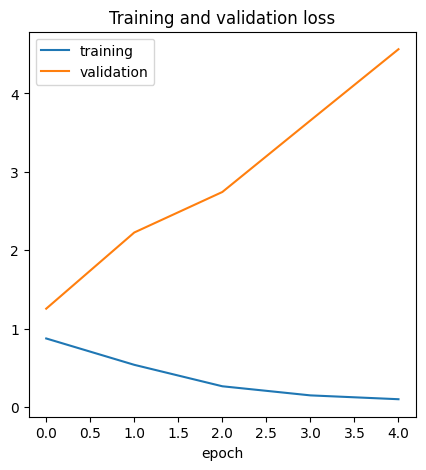

<Figure size 500x500 with 0 Axes>

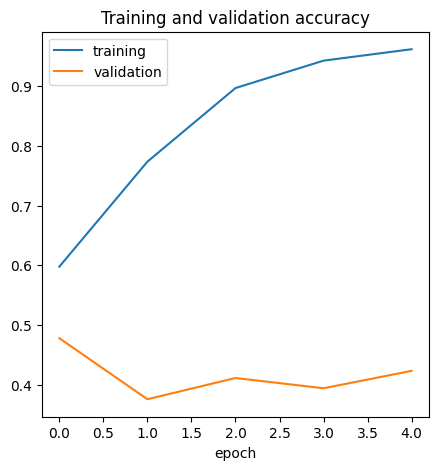

---------------------------------------------
DCCN - Random Undersampling
> Accuracy on train: 0.6 	Loss on train: 0.88
> Accuracy on test: 0.38 	Loss on test: 7.62
---------------------------------------------
> predicting test
---------------------------------------------
564/564 [==============================] - 23s 41ms/step


<Figure size 500x500 with 0 Axes>

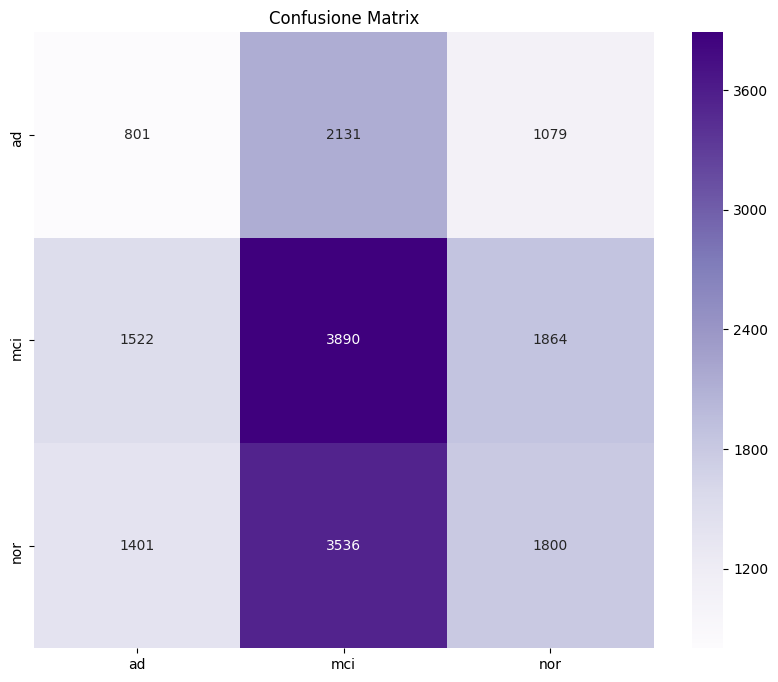

.............................................
> Correct Predictions: 6491
> Wrong Predictions: 11533
.............................................
              precision    recall  f1-score   support

          ad       0.22      0.20      0.21      4011
         mci       0.41      0.53      0.46      7276
         nor       0.38      0.27      0.31      6737

    accuracy                           0.36     18024
   macro avg       0.33      0.33      0.33     18024
weighted avg       0.35      0.36      0.35     18024



In [44]:
model_summary(net_dcnn, history, 'DCCN - Random Undersampling')